In [106]:
from sklearn.metrics import roc_curve, auc
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Goal with this model: to visualize and see the most prominent features in predicting a show/movie's popularity

In [155]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

In [153]:
print(df.columns.tolist())
df

['id', 'name', 'number_of_seasons', 'number_of_episodes', 'original_language', 'vote_count', 'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date', 'last_air_date', 'homepage', 'in_production', 'original_name', 'popularity', 'poster_path', 'type', 'status', 'tagline', 'genres', 'created_by', 'languages', 'networks', 'origin_country', 'spoken_languages', 'production_companies', 'production_countries', 'episode_run_time']


,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,type,status,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,2019-05-19,http://www.hbo.com/game-of-thrones,False,Game of Thrones,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Scripted,Ended,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,2021-12-03,https://www.netflix.com/title/80192098,False,La Casa de Papel,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg,Scripted,Ended,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,2022-07-01,https://www.netflix.com/title/80057281,True,Stranger Things,185.711,/49WJfeN0moxb9IPfGn8AIqMGskD.jpg,Scripted,Returning Series,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,2022-11-20,http://www.amc.com/shows/the-walking-dead--100...,False,The Walking Dead,489.746,/n7PVu0hSz2sAsVekpOIoCnkWlbn.jpg,Scripted,Ended,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,2021-09-10,https://www.netflix.com/title/80057918,False,Lucifer,416.668,/ekZobS8isE6mA53RAiGDG93hBxL.jpg,Scripted,Ended,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.000,NaN,False,NaN,2023-03-03,2023-03-03,NaN,True,母乳酱想要喷出来,1.400,NaN,Scripted,Returning Series,NaN,NaN,NaN,NaN,NaN,CN,NaN,NaN,NaN,0
168635,241205,Barbie Dream Squad,1,1,es,0,0.000,NaN,False,NaN,NaN,2023-03-04,NaN,False,Barbie Dream Squad,0.600,/vvm7p60THjcYdnXnXfjCgwPeime.jpg,Scripted,Ended,NaN,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,US,NaN,NaN,NaN,0
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",False,/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,2023-11-30,NaN,True,Picasso,1.895,/ifDs1gBunsaN3lAG4Imc94JcfVD.jpg,Scripted,Returning Series,NaN,Crime,NaN,bn,NaN,IN,বাংলা,NaN,India,0
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.000,A college student gets into trouble when she m...,False,NaN,1990-02-10,1990-02-10,NaN,True,女子大生危険なアルバイト,0.600,/9EO55cThzp98PaM9iVRoZPXjIZ8.jpg,Scripted,Returning Series,NaN,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,0


In [156]:
# Fill missing values for numerical + categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna('Unknown'))

# Remove duplicates
df = df.drop_duplicates()

# Handle 'genres' column (multi-label encoding)
df['genres'] = df['genres'].fillna('Unknown')
df['genres'] = df['genres'].apply(lambda x: x.split(', '))
unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

# Retain 'genres' column for now as per the requirement
# Columns to encode
encode_cols = ['original_language', 'type', 'status', 'created_by', 'networks', 'origin_country', 'production_companies']

# One-hot encoding for 'original_language' (top 10 values + 'OTHER')
top_10_original_language = df['original_language'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_original_language:
    df[f'original-language_{i}'] = np.where(df['original_language'] == i, 1, 0)
df['original-language_OTHER'] = (~df['original_language'].isin(top_10_original_language)).astype(int)
df.drop(columns=['original_language'], inplace=True)
encode_cols.remove('original_language')

# One-hot encoding for 'created_by' (top 10 values + 'OTHER')
filtered_df = df[df['created_by'] != 'Unknown']
top_10_created_by = filtered_df['created_by'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_created_by:
    df[f'created-by_{i}'] = np.where(df['created_by'] == i, 1, 0)
df['created-by_OTHER'] = (~df['created_by'].isin(top_10_created_by)).astype(int)
df.drop(columns=['created_by'], inplace=True)
encode_cols.remove('created_by')

# One-hot encoding for 'networks' (top 10 values + 'OTHER')
filtered_df = df[df['networks'] != 'Unknown']
top_10_networks = filtered_df['networks'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_networks:
    df[f'networks_{i}'] = np.where(df['networks'] == i, 1, 0)
df['networks_OTHER'] = (~df['networks'].isin(top_10_networks)).astype(int)
df.drop(columns=['networks'], inplace=True)
encode_cols.remove('networks')

# One-hot encoding for 'origin_country' (top 10 values + 'OTHER')
df['origin_country'] = df['origin_country'].fillna('Unknown')
filtered_df = df[df['origin_country'] != 'Unknown']
top_10_origin_country = filtered_df['origin_country'].value_counts(ascending=False).head(10).index.tolist()
one_hot_encoded = pd.get_dummies(df['origin_country'], prefix='origin-country')
one_hot_encoded = one_hot_encoded[[f'origin-country_{i}' for i in top_10_origin_country if f'origin-country_{i}' in one_hot_encoded]]
one_hot_encoded['origin-country_OTHER'] = (~df['origin_country'].isin(top_10_origin_country)).astype(int)
one_hot_encoded = one_hot_encoded.astype(int)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=['origin_country'], inplace=True)
encode_cols.remove('origin_country')

# One-hot encoding for 'production_companies' (top 10 values + 'OTHER')
df['production_companies'] = df['production_companies'].fillna('Unknown')
filtered_df = df[df['production_companies'] != 'Unknown']
top_10_production_companies = filtered_df['production_companies'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_production_companies:
    df[f'production-companies_{i}'] = np.where(df['production_companies'] == i, 1, 0)
df['production-companies_OTHER'] = (~df['production_companies'].isin(top_10_production_companies)).astype(int)
df.drop(columns=['production_companies'], inplace=True)
encode_cols.remove('production_companies')

# One-hot encoding for remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname)
    df_encoded = df_encoded.astype(int)
    df = pd.concat([df, df_encoded], axis=1)

# Removing remaining original columns from df
df.drop(columns=encode_cols, axis=1, inplace=True)

print(df.columns)

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'type_Reality', 'type_Scripted', 'type_Talk Show', 'type_Video',
       'status_Canceled', 'status_Ended', 'status_In Production',
       'status_Pilot', 'status_Planned', 'status_Returning Series'],
      dtype='object', length=111)


In [114]:
df

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,overview,adult,backdrop_path,first_air_date,last_air_date,homepage,in_production,original_name,popularity,poster_path,tagline,genres,languages,spoken_languages,production_countries,episode_run_time,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,History,Kids,Music,Musical,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,Unknown,War & Politics,Western,original-language_en,original-language_zh,original-language_ja,original-language_ko,original-language_de,original-language_fr,original-language_es,original-language_pt,original-language_ru,original-language_nl,original-language_OTHER,created-by_Shotaro Ishinomori,created-by_John de Mol,created-by_Adrián Suar,created-by_Simon Fuller,created-by_Ekta Kapoor,created-by_Na Young-seok,created-by_Yang Li-Hua,"created-by_Joseph Barbera, William Hanna",created-by_R.J. Nuevas,created-by_Mark Burnett,created-by_OTHER,networks_BBC One,networks_YouTube,networks_Netflix,networks_ITV1,networks_BBC Two,networks_ABC,networks_NBC,networks_TVB Jade,networks_CBS,networks_Channel 4,networks_OTHER,origin-country_US,origin-country_JP,origin-country_GB,origin-country_CN,origin-country_DE,origin-country_KR,origin-country_CA,origin-country_FR,origin-country_AU,origin-country_BR,origin-country_OTHER,production-companies_TVB,production-companies_BBC,production-companies_Estúdios Globo,production-companies_NHK,production-companies_DR TV,production-companies_TV 2,production-companies_Televisa,production-companies_GMA Entertainment Group,production-companies_Česká televize,production-companies_ATV Enterprises Limited,production-companies_OTHER,type_Documentary,type_Miniseries,type_News,type_Reality,type_Scripted,type_Talk Show,type_Video,status_Canceled,status_Ended,status_In Production,status_Pilot,status_Planned,status_Returning Series
0,1399,Game of Thrones,8,73,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,2019-05-19,http://www.hbo.com/game-of-thrones,False,Game of Thrones,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Winter Is Coming,"[Sci-Fi & Fantasy, Drama, Action & Adventure]",en,English,"United Kingdom, United States of America",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
1,71446,Money Heist,3,41,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,2021-12-03,https://www.netflix.com/title/80192098,False,La Casa de Papel,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg,The perfect robbery.,"[Crime, Drama]",es,Español,Spain,70,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
2,66732,Stranger Things,4,34,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,2022-07-01,https://www.netflix.com/title/80057281,True,Stranger Things,185.711,/49WJfeN0moxb9IPfGn8AIqMGskD.jpg,Every ending has a beginning.,"[Drama, Sci-Fi & Fantasy, Mystery]",en,English,United States of America,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1402,The Walking Dead,11,177,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,2022-11-20,http://www.amc.com/shows/the-walking-dead--100...,False,The Walking Dead,489.746,/n7PVu0hSz2sAsVekpOIoCnkWlbn.jpg,Fight the dead. Fear the living.,"[Action & Adventure, Drama, Sci-Fi & Fantasy]",en,English,United States of America,42,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [157]:
# convert the boolean values to integers (True -> 1, False -> 0)
df['adult'] = df['adult'].astype(int)

In [158]:
# Replace "Unknown" and other invalid date strings with NaT (Not a Time)
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format='%Y-%m-%d', errors='coerce')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format='%Y-%m-%d', errors='coerce')

# Check the data types to confirm conversion
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to determine the season based on the month
def get_season(date):
    if pd.isna(date):  # Handle NaT values
        return 'UNKNOWN'
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'

# Creating a column with the seasons for `first_air_date`
df['first_air_date_season'] = df['first_air_date'].apply(get_season)

# Creating boolean columns for each season
df['first_air_date_winter'] = (df['first_air_date_season'] == 'WINTER').astype(int)
df['first_air_date_spring'] = (df['first_air_date_season'] == 'SPRING').astype(int)
df['first_air_date_summer'] = (df['first_air_date_season'] == 'SUMMER').astype(int)
df['first_air_date_fall'] = (df['first_air_date_season'] == 'FALL').astype(int)

# Repeating the same process for `last_air_date`
df['last_air_date_season'] = df['last_air_date'].apply(get_season)

df['last_air_date_winter'] = (df['last_air_date_season'] == 'WINTER').astype(int)
df['last_air_date_spring'] = (df['last_air_date_season'] == 'SPRING').astype(int)
df['last_air_date_summer'] = (df['last_air_date_season'] == 'SUMMER').astype(int)
df['last_air_date_fall'] = (df['last_air_date_season'] == 'FALL').astype(int)

# Confirm the columns
print(df[['first_air_date_season', 'last_air_date_season']].head())

datetime64[ns]
datetime64[ns]
  first_air_date_season last_air_date_season
0                SPRING               SPRING
1                SPRING               WINTER
2                SUMMER               SUMMER
3                  FALL                 FALL
4                WINTER                 FALL


In [159]:
columns_to_drop = [
  'tagline', 'id', 'backdrop_path', 'homepage', 
  'original_name', 'poster_path', 'languages', 
  'spoken_languages', 'name', 'first_air_date', 
  'last_air_date', 'last_air_date_season', 'first_air_date_season', 
  'in_production', 'production_countries', 'match', 'genres', 'predicted_genres', 'overview'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

In [160]:
df

,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,popularity,episode_run_time,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,History,Kids,Music,Musical,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,Unknown,War & Politics,Western,original-language_en,original-language_zh,original-language_ja,original-language_ko,original-language_de,original-language_fr,original-language_es,original-language_pt,original-language_ru,original-language_nl,original-language_OTHER,created-by_Shotaro Ishinomori,created-by_John de Mol,created-by_Adrián Suar,created-by_Simon Fuller,created-by_Ekta Kapoor,created-by_Na Young-seok,created-by_Yang Li-Hua,"created-by_Joseph Barbera, William Hanna",created-by_R.J. Nuevas,created-by_Mark Burnett,created-by_OTHER,networks_BBC One,networks_YouTube,networks_Netflix,networks_ITV1,networks_BBC Two,networks_ABC,networks_NBC,networks_TVB Jade,networks_CBS,networks_Channel 4,networks_OTHER,origin-country_US,origin-country_JP,origin-country_GB,origin-country_CN,origin-country_DE,origin-country_KR,origin-country_CA,origin-country_FR,origin-country_AU,origin-country_BR,origin-country_OTHER,production-companies_TVB,production-companies_BBC,production-companies_Estúdios Globo,production-companies_NHK,production-companies_DR TV,production-companies_TV 2,production-companies_Televisa,production-companies_GMA Entertainment Group,production-companies_Česká televize,production-companies_ATV Enterprises Limited,production-companies_OTHER,type_Documentary,type_Miniseries,type_News,type_Reality,type_Scripted,type_Talk Show,type_Video,status_Canceled,status_Ended,status_In Production,status_Pilot,status_Planned,status_Returning Series,first_air_date_winter,first_air_date_spring,first_air_date_summer,first_air_date_fall,last_air_date_winter,last_air_date_spring,last_air_date_summer,last_air_date_fall
0,8,73,21857,8.442,0,1083.917,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,3,41,17836,8.257,0,96.354,70,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,4,34,16161,8.624,0,185.711,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,11,177,15432,8.121,0,489.746,42,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,6,93,13870,8.486,0,416.668,45,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,1,1,0,0.000,0,1.400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
168635,1,1,0,0.000,0,0.600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
168636,1,1,0,0.000,0,1.895,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [161]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())

   number_of_seasons  number_of_episodes  vote_count  vote_average  adult  \
0                  8                  73       21857         8.442      0   
1                  3                  41       17836         8.257      0   
2                  4                  34       16161         8.624      0   
3                 11                 177       15432         8.121      0   
4                  6                  93       13870         8.486      0   

   popularity  episode_run_time  Action & Adventure  Animation  Comedy  Crime  \
0    1083.917                 0                   1          0       0      0   
1      96.354                70                   0          0       0      1   
2     185.711                 0                   0          0       0      0   
3     489.746                42                   1          0       0      0   
4     416.668                45                   0          0       0      1   

   Documentary  Drama  Family  History  Kids  Musi

In [162]:
#Winsorization
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Winsorize each numerical column in-place
for col in numerical_columns:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

# Winsorize each log-transformed numerical column in-place
for col in numerical_columns_log:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

In [163]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling in-place
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Display the updated DataFrame to confirm normalized columns
print(df.head())

   number_of_seasons  number_of_episodes  vote_count  vote_average  adult  \
0               1.00            0.802198         1.0      0.938000      0   
1               0.75            0.450549         1.0      0.917444      0   
2               1.00            0.373626         1.0      0.958222      0   
3               1.00            1.000000         1.0      0.902333      0   
4               1.00            1.000000         1.0      0.942889      0   

   popularity  episode_run_time  Action & Adventure  Animation  Comedy  Crime  \
0         1.0              0.00                 1.0        0.0     0.0    0.0   
1         1.0              1.00                 0.0        0.0     0.0    1.0   
2         1.0              0.00                 0.0        0.0     0.0    0.0   
3         1.0              0.70                 1.0        0.0     0.0    0.0   
4         1.0              0.75                 0.0        0.0     0.0    1.0   

   Documentary  Drama  Family  History  Kids  Musi

In [ ]:
# Johnathan's method

In [164]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 
        # Genres
        'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 
        'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 
        'Unknown', 'War & Politics', 'Western',
        # Original Language
        'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_OTHER', 
        # Created By
        'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 
        'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 
        'created-by_Yang Li-Hua', 'created-by_Joseph Barbera, William Hanna', 
        'created-by_R.J. Nuevas', 'created-by_Mark Burnett', 
        'created-by_OTHER', 
        # Networks
        'networks_BBC One', 'networks_YouTube', 'networks_Netflix', 
        'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 'networks_NBC', 
        'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_OTHER', 
        # Origin Country
        'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 
        'origin-country_CA', 'origin-country_FR', 'origin-country_AU', 
        'origin-country_BR', 'origin-country_OTHER', 
        # Production Companies
        'production-companies_TVB', 'production-companies_BBC', 
        'production-companies_Estúdios Globo', 'production-companies_NHK', 
        'production-companies_DR TV', 'production-companies_TV 2', 
        'production-companies_Televisa', 'production-companies_GMA Entertainment Group', 
        'production-companies_Česká televize', 'production-companies_ATV Enterprises Limited', 
        'production-companies_OTHER', 
        # Types
        'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality', 
        'type_Scripted', 'type_Talk Show', 'type_Video', 
        # Status
        'status_Canceled', 'status_Ended', 'status_In Production', 
        'status_Pilot', 'status_Planned', 'status_Returning Series'
]]
y = df['popularity_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=42)
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse) 
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Training Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R-squared (R2): {train_r2:.4f}")

print("\nTesting Set Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-squared (R2): {test_r2:.4f}")

Training Set Metrics:
Mean Squared Error (MSE): 0.0287
Root Mean Squared Error (RMSE): 0.1695
Mean Absolute Error (MAE): 0.1115
R-squared (R2): 0.6682

Testing Set Metrics:
Mean Squared Error (MSE): 0.0289
Root Mean Squared Error (RMSE): 0.1699
Mean Absolute Error (MAE): 0.1111
R-squared (R2): 0.6620


In [ ]:
# https://how2matplotlib.com/how-to-create-a-residual-plot-in-python.html
residuals = y_test - y_test_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

C:\Users\xrli2\AppData\Local\Temp\ipykernel_55100\3447917992.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Importance', data=features_df, palette="viridis")


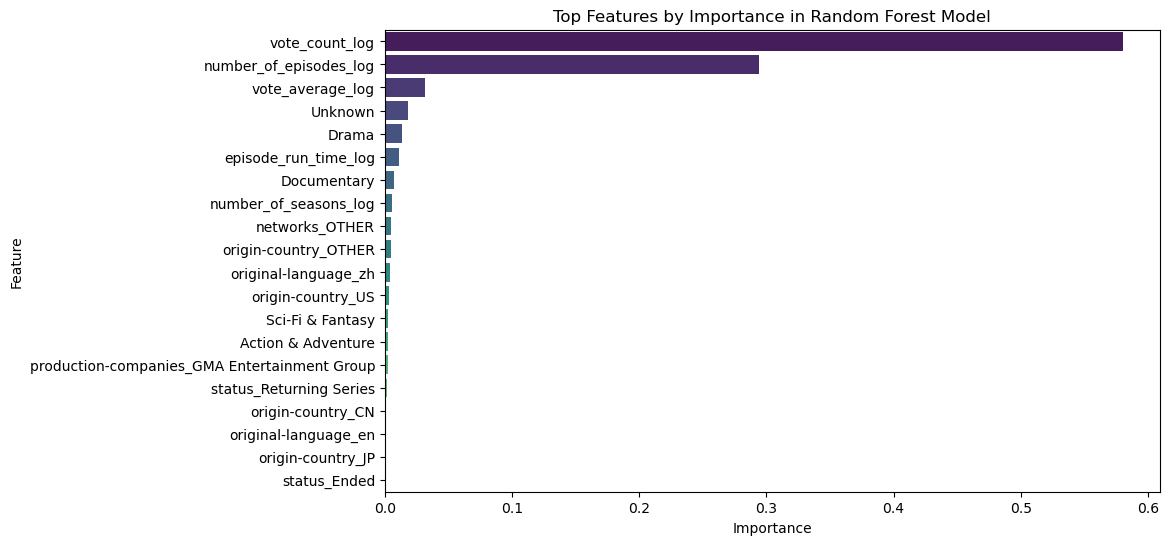

In [166]:
# Get feature importances
feature_importances = regressor.feature_importances_

features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False).head(20)  # Top 10 features

# Plot the minimal depth approximation (importance) distribution
plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Importance', data=features_df, palette="viridis")
plt.title("Top Features by Importance in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# GBDR

In [129]:
X = df.drop(columns=['popularity'], axis=1)
y = df['popularity']                     

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
y_train

In [137]:
# Before training on the Gradient Boosted DT, I first train on a simple decision tree

def train_test_DT(X_train, X_test, y_train, y_test, leaf, depth, crit='squared_error'):
    model = DecisionTreeRegressor(min_samples_leaf=leaf, max_depth=depth, criterion=crit)
    model.fit(X_train, y_train)
    class_label_predictions = model.predict(X_test)
    #mse_score = mean_squared_error(y_test, class_label_predictions)
    #return mse_score
    return r2_score(class_label_predictions, y_test)

In [150]:
max_depth_range = [15]

acc = []

for md in max_depth_range:
    score = train_test_DT(X_train, X_test, y_train, y_test, 15, md)
    print('Max Depth=' + str(md) + ', r2 score: ' + str(score))
    acc.append(float(score))

Max Depth=15, r2 score: 1.0


In [143]:
# GBDT Classifier 
y_bins = pd.cut(df["popularity"], bins=3, labels=[0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(
   X, y_bins, test_size=0.2, random_state=42
)

def GradientBoostingClassifierModel(X_train, y_train, X_test, n_estimators, max_depth):
   model = GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth)
   model.fit(X_train, y_train)
   model_preds = model.predict_proba(X_test)
   return model, model_preds[:, -1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

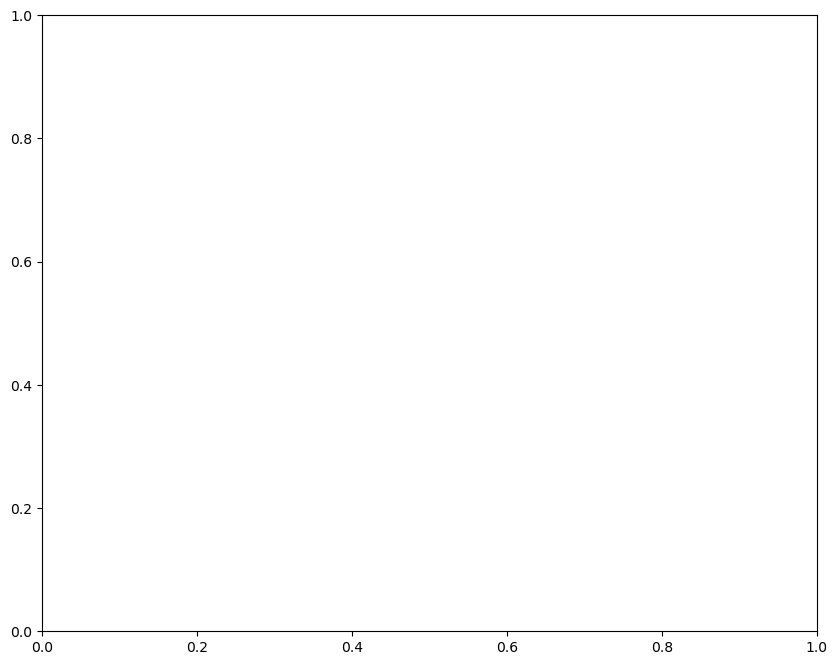

In [ ]:
n_estimators = [50] 
max_depths = [2, 4, 7, 10, 20] 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for n_est in n_estimators:
    for depth in max_depths:
        model, y_pred_proba = GradientBoostingClassifierModel(X_train, y_train, X_test, n_est, depth)
        assert len(y_pred_proba.shape) == 2
        for i in range(len(model.classes_)):  
            fpr, tpr, _ = roc_curve((y_test == model.classes_[i]).astype(int), y_pred_proba[:, i])
            auc_x = auc(fpr, tpr)

            ax.plot(fpr, tpr, label=f"Class {model.classes_[i]}, n_estimators={n_est}, max_depth={depth}, AUC={auc_x:.3f}")

ax.set_title("ROC Curve for Gradient Boosting Classifier")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="best")
plt.show()

In [ ]:
# Terrible scores, will try GBRegressor
regressor = GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

# Root Mean Squared Error (RMSE)
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse:.3f}")

# R2 Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.3f}")

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

In [ ]:
# Residuals
y_test = pd.Series(y_test)  
y_test = pd.to_numeric(y_test, errors='coerce')  
y_pred = np.array(y_pred, dtype=float)

residuals = y_test - y_pred

# Histogram of residuals
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

In [ ]:
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Target Values")
plt.ylabel("Frequency")
plt.title("Distribution of Target Values")
plt.show()

In [ ]:
df['popularity']

In [ ]:
y